# Preprocessing the data

## Import the modules

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats 
import matplotlib.pylab as plt
import scipy.io
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

## Load the data

(12, 15000, 75) (12, 15000, 75)
(32, 1) (31, 1)


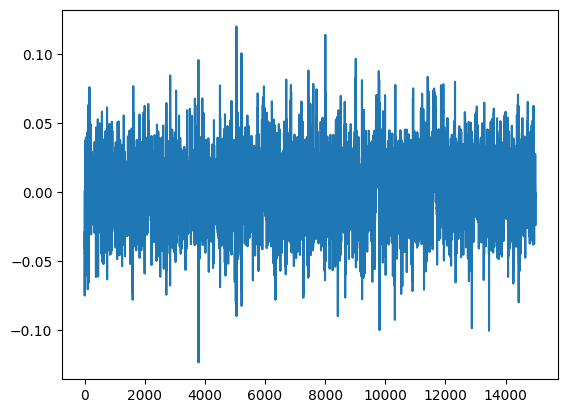

In [2]:
# load mat file
Xva = scipy.io.loadmat("Xva.mat")
Xa = scipy.io.loadmat("Xa.mat")
Rva = Xva['Xva']
Ra = Xa['Xa']

# load mat file
recur = scipy.io.loadmat("indrecur.mat")
no_recur = scipy.io.loadmat("indnonrecur.mat")
recur = recur['indrecur']
no_recur = no_recur['indnonrecur']


print(Ra.shape, Rva.shape)
print(recur.shape, no_recur.shape)
plt.plot(Ra[1,:,1])

--------------------------------------------------------------------------------------------------------------------------------
## Preprocessing of the data
--------------------------------------------------------------------------------------------------------------------------------
#### Feature extraction part is done with the collaboration of my colleagues (Hyelim Lee and Anjana Batt)
--------------------------------------------------------------------------------------------------------------------------------

In [3]:
# convert data to list 
recur = recur.flatten().tolist() 
no_recur = no_recur.flatten().tolist()

# The index will shift to -1, like in matlab starts from 1 and in python starts from 0.
# We need to shift to "x-1".
recur = [x - 1 for x in recur] 
no_recur = [x - 1 for x in no_recur]

# Selecting V1 to V6 leads
Ra = Ra[6:12, :, :]
Rva = Rva[6:12, :, :]
print(Ra.shape)

(6, 15000, 75)


In [4]:
# Reconstruct data for feature extraction
def convert_data(X):
    signallist = ['v1','v2','v3','v4','v5','v6']
    formatted_signals = []
    converted_data = {}
    # Iteration through every segnal
    for i, signal in enumerate(signallist):
        data = X[i,:,:]
        re_data = data.T
        # Iterate through each patient number
        for patient_num in range(0, X.shape[2]):
            # Format the signal name with the patient number and append to the list
            data_pat = re_data[patient_num,:]
            signal_pat = f"{signal}_{patient_num}"
            converted_data[signal_pat] = data_pat
    return converted_data


In [5]:
#Converting data in dictionary format
converted_Ra = convert_data(Ra)
converted_Rva = convert_data(Rva)

In [6]:
converted_Ra #Like we can see

{'v1_0': array([-0.01158859, -0.01078397, -0.00596672, ..., -0.01370395,
        -0.01244296, -0.01133642]),
 'v1_1': array([0.01712211, 0.0405    , 0.04540617, ..., 0.03514144, 0.03129789,
        0.02106919]),
 'v1_2': array([ 0.00130679,  0.00682618,  0.01281056, ...,  0.01073962,
         0.00820366, -0.00205856]),
 'v1_3': array([-0.00789068, -0.00749467,  0.00225202, ...,  0.00312826,
         0.00531946, -0.00774204]),
 'v1_4': array([ 0.00698672,  0.0101801 ,  0.00729624, ..., -0.03078683,
        -0.0325078 , -0.03329165]),
 'v1_5': array([ 0.0057983 ,  0.02117538,  0.02093791, ..., -0.00560035,
        -0.00123211,  0.00675514]),
 'v1_6': array([-0.03597142, -0.024653  ,  0.00080743, ..., -0.20849605,
        -0.23543061, -0.21360342]),
 'v1_7': array([ 0.01159022,  0.01844159,  0.01637054, ..., -0.03951385,
        -0.03681079, -0.03024703]),
 'v1_8': array([ 0.00198205, -0.00264435, -0.00244647, ..., -0.00174946,
         0.00046746, -0.00194855]),
 'v1_9': array([ 0.012803

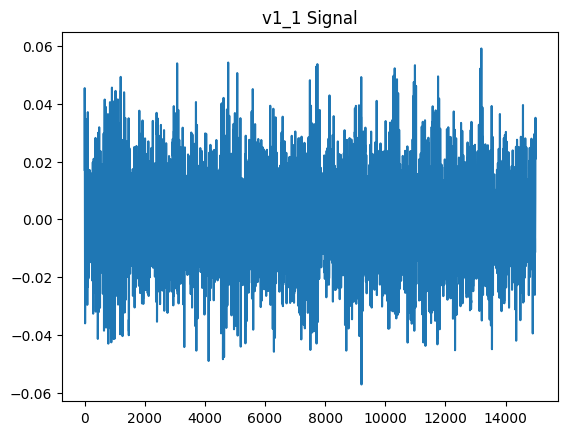

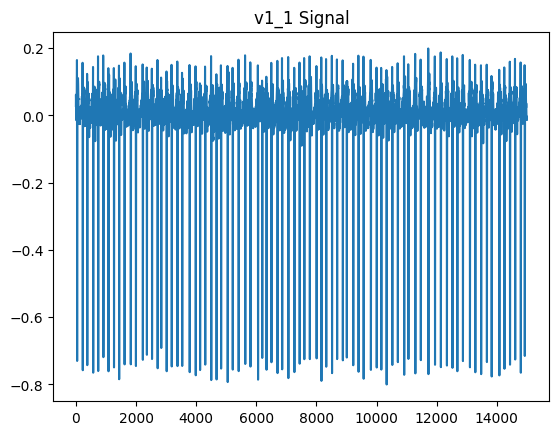

In [7]:
plt.plot(list(converted_Ra.values())[1])
plt.title(f"{list(converted_Ra.keys())[1]} Signal")
plt.show()
plt.plot(list(converted_Rva.values())[1])
plt.title(f"{list(converted_Rva.keys())[1]} Signal")
plt.show()

In [8]:
import scipy.signal as signal

def diff_stat(Rva_array):
    x = np.array(Rva_array)
    locs, _ = signal.find_peaks(x, height=x.max()/2)
    if len(locs) >= 2:
        diff = np.diff(locs)
        df = pd.DataFrame(data = [diff.max(), diff.min(), diff.mean(), diff.std(),
                                  stats.kurtosis(diff), stats.skew(diff), np.quantile(diff,0.5)]).T
        df.columns = ['max_diff', 'min_diff', 'mean_diff', 'sd_diff', 'ku_diff', 'sk_diff', 'median_diff']
    else:
        df = pd.DataFrame(data = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,np.nan]).T
        df.columns = ['max_diff', 'min_diff', 'mean_diff', 'sd_diff', 'ku_diff', 'sk_diff', 'median_diff']
    return df, locs

def seg_stat(Ra_array, locs):
    x = np.array(Ra_array)
    seg_df = pd.DataFrame()
    for i in range(0,len(locs)-1):
        seg =x[locs[i]:locs[i+1]]
        peaks_seg,_ = signal.find_peaks(seg, height=seg.max()/2)
        tmp_df = pd.DataFrame(data = [len(seg), seg.mean(), seg.max(), seg.min(),len(peaks_seg)]).T
        tmp_df.columns = ['len_seg', 'mean_seg', 'max_seg', 'min_seg', 'peaks_seg']
        seg_df = pd.concat([seg_df, tmp_df], axis=0) 

    df = pd.DataFrame(seg_df.mean()).T
    return df
    
def ecg_stat(Ra_array):
    # Input: An array (numpy, dataframe, list) 
    # -> Output : A pd.DataFrame
    
    x = np.array(Ra_array)
    
    df = pd.DataFrame(data = [x.max(), x.min(), np.mean(abs(x)), x.std(),
                              stats.kurtosis(x), stats.skew(x), np.quantile(x,0.5),
                              np.quantile(x, 0.25), np.quantile(x,0.75),
                              np.quantile(x, 0.05), np.quantile(x, 0.95)]).T
    df.columns = ['max_ecg', 'min_ecg', 'meanabs_ecg', 'sd_ecg', 'ku_ecg', 'sk_ecg', 'median_ecg',
                  'q1_ecg', 'q3_ecg', 'q05_ecg', 'q95_ecg']
    
    return df

def stat_features(Ra, Rva):
    dic_Ra = Ra.copy()
    dic_Rva = Rva.copy()
    
    names = []
    ecg = pd.DataFrame()
    diff = pd.DataFrame()
    seg = pd.DataFrame()
    for i in range(len(Ra)):
        k = list(dic_Ra.keys())[i]
        ra = list(dic_Ra.values())[i]
        rva = list(dic_Rva.values())[i]
        
        ecg = pd.concat([ecg, ecg_stat(ra)], axis=0) 
        diff_tmp, locs_tmp = diff_stat(rva)
        diff = pd.concat([diff, diff_tmp], axis=0) 
        seg = pd.concat([seg, seg_stat(ra, locs_tmp)], axis=0) 
        
        df_stat = pd.concat([ecg, diff, seg], axis=1) 
        names.append(k)
    
    df_stat= df_stat.set_axis(names)
    return df_stat

In [9]:
df_stat = stat_features(converted_Ra, converted_Rva)

# add the label in the dataframe
df = df_stat.copy()
df = df.reset_index() 

df["signal_num"] = np.nan
df["patient_num"] = np.nan
df["label"] = np.nan
for i in range(len(df)):
    patient_num = int(df['index'][i].split('_')[-1])
    df['signal_num'][i] = df['index'][i].split('_')[0]
    df['patient_num'][i] = patient_num
    if patient_num in recur:
        df['label'][i] = 1
    elif patient_num in no_recur:
        df['label'][i] = 0
    else :
        df['label'][i] = -1

df = df.drop('index',axis=1)

df = df[df['label'] != -1] # label


df = df.reset_index().drop('index',axis=1)
df = df.dropna() 
df

C:\Users\Raffaele\AppData\Local\Temp\ipykernel_109900\3439723613.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.kurtosis(diff), stats.skew(diff), np.quantile(diff,0.5)]).T
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_109900\3439723613.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stats.kurtosis(diff), stats.skew(diff), np.quantile(diff,0.5)]).T
C:\Users\Raffaele\AppData\Local\Temp\ipykernel_109900\470391488.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal_num'][i] = df['index'][i].split('_')[0]
C:\Users\Raffaele\AppData

,max_ecg,min_ecg,meanabs_ecg,sd_ecg,ku_ecg,sk_ecg,median_ecg,q1_ecg,q3_ecg,q05_ecg,...,sk_diff,median_diff,len_seg,mean_seg,max_seg,min_seg,peaks_seg,signal_num,patient_num,label
0,0.112801,-0.176020,0.023904,0.029767,0.114096,0.115269,-0.000730,-0.021217,0.019912,-0.046272,...,0.395806,203.0,207.901408,-0.000093,0.066552,-0.062910,5.985915,v1,0.0,0.0
1,0.059136,-0.057175,0.012300,0.015474,-0.005221,0.049944,-0.000014,-0.010550,0.010232,-0.025227,...,-0.299730,150.5,124.091667,0.002040,0.034433,-0.027457,4.891667,v1,1.0,1.0
2,0.053388,-0.044402,0.010041,0.012656,0.062166,0.111068,-0.000341,-0.008456,0.008327,-0.020794,...,0.219057,96.5,94.202532,0.002004,0.024149,-0.018044,3.525316,v1,2.0,0.0
3,0.049817,-0.046310,0.009489,0.012080,0.173318,0.083084,-0.000172,-0.007816,0.007716,-0.019636,...,1.484075,41.0,74.457711,0.002629,0.025815,-0.017517,2.572139,v1,3.0,0.0
4,0.059395,-0.056222,0.010357,0.012952,0.002436,0.031496,-0.000079,-0.008907,0.008672,-0.021154,...,1.679346,256.0,267.436364,-0.000019,0.031958,-0.031994,8.981818,v1,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,0.068409,-0.092659,0.009909,0.013457,3.925464,-0.511300,0.000335,-0.007258,0.008088,-0.020356,...,0.826378,207.0,208.422535,0.000241,0.033307,-0.037750,6.619718,v6,70.0,1.0
374,0.102700,-0.087082,0.009492,0.013619,5.717749,-0.002892,0.000055,-0.006930,0.007030,-0.019499,...,1.268313,199.0,217.941176,0.000029,0.037241,-0.039429,4.117647,v6,71.0,1.0
375,0.120183,-0.073214,0.014416,0.018849,1.342055,0.425637,-0.000759,-0.011676,0.011178,-0.029374,...,0.169275,159.0,157.797872,0.000255,0.050188,-0.038830,3.085106,v6,72.0,0.0
376,0.035760,-0.058107,0.006360,0.008318,1.936873,-0.231161,-0.000133,-0.005190,0.005185,-0.012958,...,2.500485,232.0,269.236364,-0.000124,0.021456,-0.024912,6.436364,v6,73.0,0.0


--------------------------------------------------------------------------------------------------------------------------------
## MACHINE LEARNING MODELS
--------------------------------------------------------------------------------------------------------------------------------

In [10]:
X = df.drop(['label','patient_num','signal_num'], axis=1)
y = df['label']

# Split data into training and testing sets (I'm going to use 25% for testing and 75 for training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("train shape:", X_train.shape, y_train.shape)
print("test shape:", X_test.shape, y_test.shape)

train shape: (276, 23) (276,)
test shape: (92, 23) (92,)


--------------------------------------------------------------------------------------------------------------------------------
### SVM
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.5108695652173914
              precision    recall  f1-score   support

         0.0       0.57      0.42      0.48        50
         1.0       0.47      0.62      0.54        42

    accuracy                           0.51        92
   macro avg       0.52      0.52      0.51        92
weighted avg       0.52      0.51      0.51        92



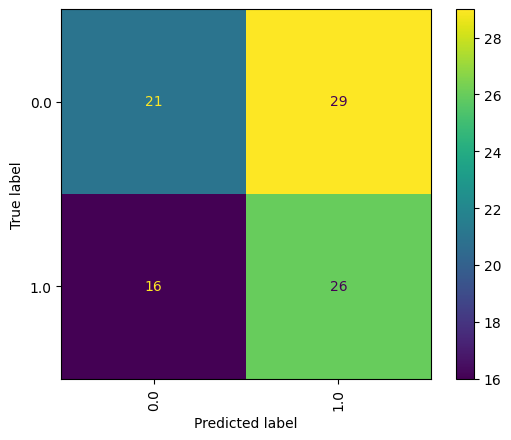

In [11]:

svm_classifier = SVC(kernel='linear')  #linear kernel

# Fit the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Predict
y_pred = svm_classifier.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(
    svm_classifier, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Gradient Boosting Classifier
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7282608695652174
              precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        50
         1.0       0.66      0.83      0.74        42

    accuracy                           0.73        92
   macro avg       0.74      0.74      0.73        92
weighted avg       0.75      0.73      0.73        92



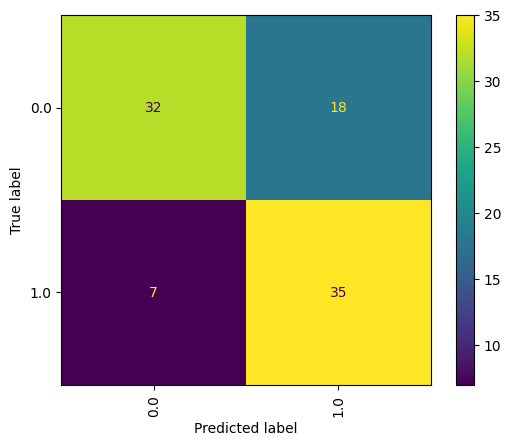

In [12]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

# Predict 
y_pred = gbc.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    gbc, X_test, y_test, xticks_rotation="vertical"
)


--------------------------------------------------------------------------------------------------------------------------------
### XGBoost
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

         0.0       0.82      0.66      0.73        50
         1.0       0.67      0.83      0.74        42

    accuracy                           0.74        92
   macro avg       0.75      0.75      0.74        92
weighted avg       0.76      0.74      0.74        92



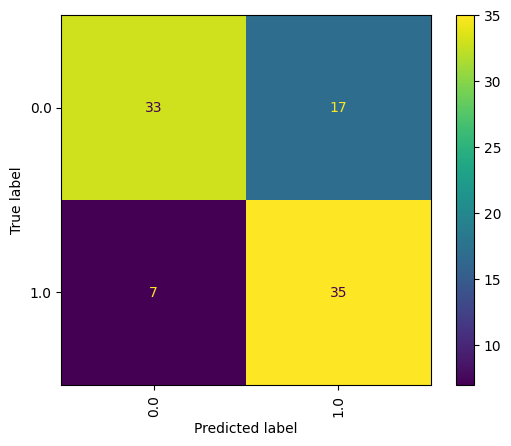

In [13]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train)

# Predict 
y_pred = xgb.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    xgb, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Random Forest
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7717391304347826
              precision    recall  f1-score   support

         0.0       0.87      0.68      0.76        50
         1.0       0.70      0.88      0.78        42

    accuracy                           0.77        92
   macro avg       0.78      0.78      0.77        92
weighted avg       0.79      0.77      0.77        92



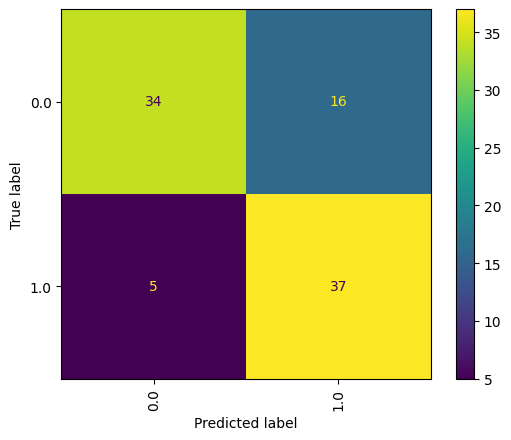

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

# Predict
y_pred = rfc.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    rfc, X_test, y_test, xticks_rotation="vertical"
)



--------------------------------------------------------------------------------------------------------------------------------
#### Logistic Regression
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.5543478260869565
Classification Report:


C:\Users\Raffaele\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


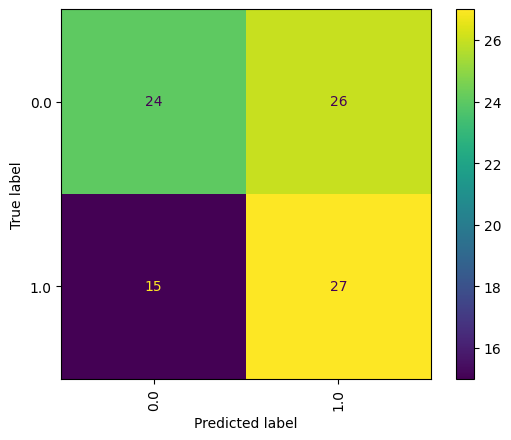

In [15]:
log_reg = LogisticRegression()

# Train the model on the training data
log_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")

ConfusionMatrixDisplay.from_estimator(
    log_reg, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
#### Decision Trees
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.6630434782608695


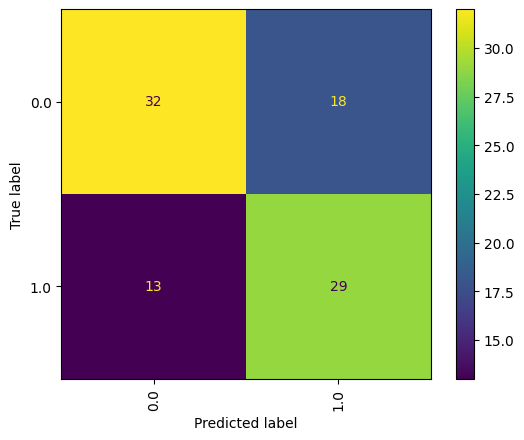

In [16]:
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
tree_clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = tree_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ConfusionMatrixDisplay.from_estimator(
    tree_clf, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
#### Naive Bayes
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.5434782608695652


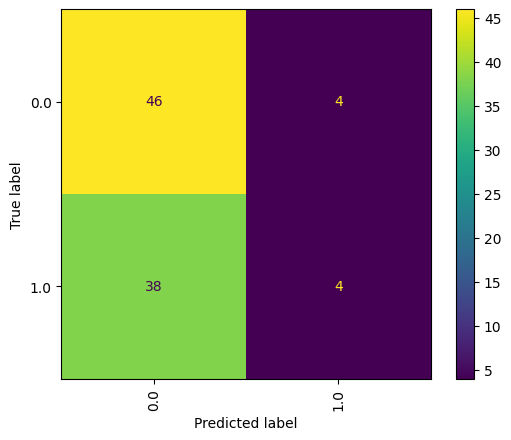

In [17]:
nb_clf = GaussianNB()

# Train
nb_clf.fit(X_train, y_train)

# Make 
y_pred = nb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ConfusionMatrixDisplay.from_estimator(
    nb_clf, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Neural Networks
--------------------------------------------------------------------------------------------------------------------------------

In [18]:
# One-hot encode the target variable
encoder = OneHotEncoder(categories='auto')
y_onehot = encoder.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()

# Split the data into training and testing sets
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_train, y_onehot, test_size=0.5, random_state=42)

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(X_train_NN.shape[1],)),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_NN, y_train_NN, epochs=50, batch_size=32, verbose=1)

# Make predictions on the testing data
y_pred = model.predict(X_test_NN)
y_pred_classes = tf.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(tf.argmax(y_test_NN, axis=1), y_pred_classes)
print("Accuracy:", accuracy)



Epoch 1/50


7/7 [==============================] - 2s 5ms/step - loss: 112.8229 - accuracy: 0.4409
Epoch 2/50
7/7 [==============================] - 0s 4ms/step - loss: 90.0025 - accuracy: 0.4409
Epoch 3/50
7/7 [==============================] - 0s 4ms/step - loss: 67.7309 - accuracy: 0.4409
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 45.8767 - accuracy: 0.4364
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 33.4655 - accuracy: 0.4318
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 29.1119 - accuracy: 0.4318
Epoch 7/50
7/7 [==============================] - 0s 7ms/step - loss: 25.5961 - accuracy: 0.4182
Epoch 8/50
7/7 [==============================] - 0s 6ms/step - loss: 22.4999 - accuracy: 0.4409
Epoch 9/50
7/7 [==============================] - 0s 4ms/step - loss: 21.5548 - accuracy: 0.5000
Epoch 10/50
7/7 [==============================] - 0s 4ms/step - loss: 20.3599 - accuracy: 0.4909
Epoch 11/50
7/7 [=======

--------------------------------------------------------------------------------------------------------------------------------
#### Ada Boost Classifier
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.6739130434782609


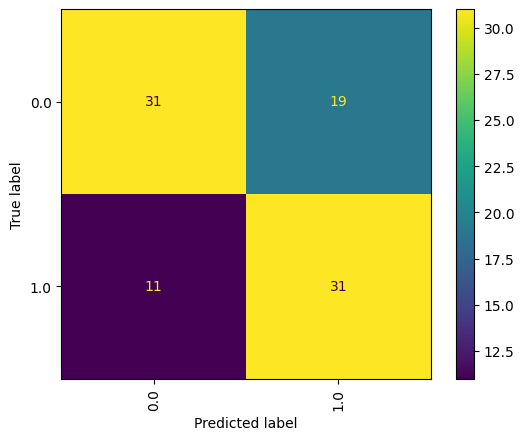

In [19]:
adaboost_clf = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train 
adaboost_clf.fit(X_train, y_train)

# Make predictions 
y_pred = adaboost_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ConfusionMatrixDisplay.from_estimator(
    adaboost_clf, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
#### Pipeline
--------------------------------------------------------------------------------------------------------------------------------

In [20]:
#pipelines for each classifier
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

gradient_boosting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier())
])

random_forest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

logistic_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])

decision_tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])

gaussian_nb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', GaussianNB())
])

adaboost_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier())
])

#Pipelines in a dictionary for easy access
classifiers = {
    'SVM': svm_pipeline,
    'GradientBoosting': gradient_boosting_pipeline,
    'XGBoost': xgb_pipeline,
    'RandomForest': random_forest_pipeline,
    'LogisticRegression': logistic_regression_pipeline,
    'DecisionTree': decision_tree_pipeline,
    'GaussianNB': gaussian_nb_pipeline,
    'AdaBoost': adaboost_pipeline
}

In [21]:
#Parameter grids for each classifier
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0.0, 0.1, 1.0]
}

gradient_boosting_param_grid = {
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.1, 1.0],
    'gb__max_depth': [3, 5, 7],
    'gb__min_samples_split': [2, 5, 10],
    'gb__min_samples_leaf': [1, 2, 4],
    'gb__subsample': [0.8, 0.9, 1.0]
}

xgb_param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__learning_rate': [0.01, 0.1, 1.0],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0],
    'xgb__gamma': [0, 0.1, 1.0],
    'xgb__reg_alpha': [0, 0.1, 1.0],
    'xgb__reg_lambda': [0, 0.1, 1.0]
}

random_forest_param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

logistic_regression_param_grid = {
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

decision_tree_param_grid = {
    'dt__max_depth': [None, 5, 10],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': ['auto', 'sqrt', 'log2']
}

gaussian_nb_param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7]
}

adaboost_param_grid = {
    'adaboost__n_estimators': [50, 100, 150],
    'adaboost__learning_rate': [0.01, 0.1, 1.0],
    'adaboost__algorithm': ['SAMME', 'SAMME.R']
}
# Define parameter grid dictionary
param_grids = {
    'SVM': svm_param_grid,
    'GradientBoosting': gradient_boosting_param_grid,
    'XGBoost': xgb_param_grid,
    'RandomForest': random_forest_param_grid,
    'LogisticRegression': logistic_regression_param_grid,
    'DecisionTree': decision_tree_param_grid,
    'GaussianNB': gaussian_nb_param_grid,
    'AdaBoost': adaboost_param_grid
}

#Grid search with cross-validation for each pipeline
best_models = {}
#for classifier_name, pipeline in classifiers.items():
#    print(f"Tuning hyperparameters for {classifier_name}...")
#    grid_search = GridSearchCV(pipeline, param_grids[classifier_name], cv=5, n_jobs=-1)
#    grid_search.fit(X_train, y_train)
#    best_models[classifier_name] = grid_search.best_estimator_
#    print(f"Best hyperparameters for {classifier_name}: {grid_search.best_params_}")
#    print(f"Best cross-validation score: {grid_search.best_score_}")

Tuning hyperparameters for SVM...
Best hyperparameters for SVM: {'svm__C': 0.1, 'svm__coef0': 1.0, 'svm__degree': 4, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best cross-validation score: 0.5533333333333333

Tuning hyperparameters for GradientBoosting...
Best hyperparameters for GradientBoosting: {'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__min_samples_leaf': 1, 'gb__min_samples_split': 2, 'gb__n_estimators': 150, 'gb__subsample': 1.0}
Best cross-validation score: 0.7133333333333335

Tuning hyperparameters for XGBoost...
Best hyperparameters for XGBoost: {'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 1.0, 'xgb__max_depth': 5, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 0.1, 'xgb__subsample': 0.8}
Best cross-validation score: 0.7033333333333334
Tuning hyperparameters for RandomForest...

Best hyperparameters for RandomForest: {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 50}
Best cross-validation score: 0.6199999999999999
Tuning hyperparameters for LogisticRegression...

Best hyperparameters for LogisticRegression: {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Best cross-validation score: 0.5833333333333334
Tuning hyperparameters for DecisionTree...

Best hyperparameters for DecisionTree: {'dt__max_depth': 10, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2}
Best cross-validation score: 0.6133333333333334

Tuning hyperparameters for GaussianNB...
Best hyperparameters for GaussianNB: {'nb__var_smoothing': 1e-09}
Best cross-validation score: 0.44000000000000006

Tuning hyperparameters for AdaBoost...
Best hyperparameters for AdaBoost: {'adaboost__algorithm': 'SAMME.R', 'adaboost__learning_rate': 0.1, 'adaboost__n_estimators': 150}
Best cross-validation score: 0.5733333333333335

##### I'm running only one time, it takes a loot of time, I saved the best parameters

--------------------------------------------------------------------------------------------------------------------------------
### The models after the GridSearch
--------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------------
### Svm 
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.45652173913043476
              precision    recall  f1-score   support

         0.0       0.50      0.06      0.11        50
         1.0       0.45      0.93      0.61        42

    accuracy                           0.46        92
   macro avg       0.48      0.49      0.36        92
weighted avg       0.48      0.46      0.34        92



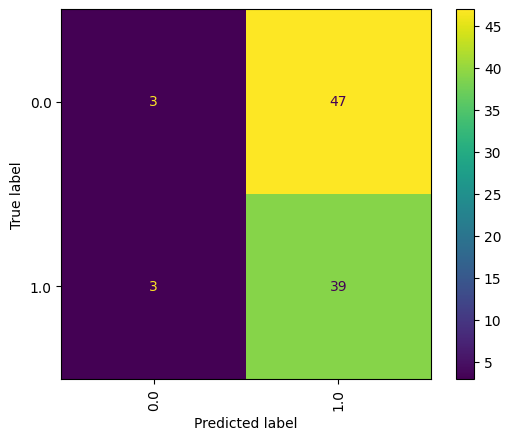

In [22]:
svm_classifier_h = SVC(kernel='poly', C=0.1, coef0=1.0, degree=4, gamma='scale')


svm_classifier_h.fit(X_train, y_train)

# Predict
y_pred = svm_classifier_h.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(
    svm_classifier_h, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Gradient Boosting Classifier
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7934782608695652
              precision    recall  f1-score   support

         0.0       0.88      0.72      0.79        50
         1.0       0.73      0.88      0.80        42

    accuracy                           0.79        92
   macro avg       0.80      0.80      0.79        92
weighted avg       0.81      0.79      0.79        92



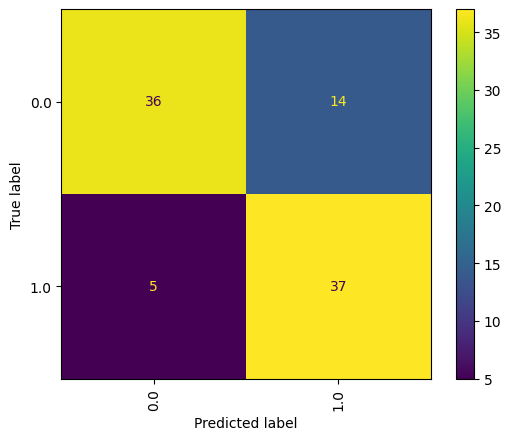

In [23]:
gbc_h = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, min_samples_leaf=1,
                                   min_samples_split=2, n_estimators=150, subsample=1.0)

gbc_h.fit(X_train, y_train)

# Predict
y_pred = gbc_h.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    gbc_h, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### XGB Classifier
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7065217391304348
              precision    recall  f1-score   support

         0.0       0.79      0.62      0.70        50
         1.0       0.64      0.81      0.72        42

    accuracy                           0.71        92
   macro avg       0.72      0.71      0.71        92
weighted avg       0.72      0.71      0.71        92



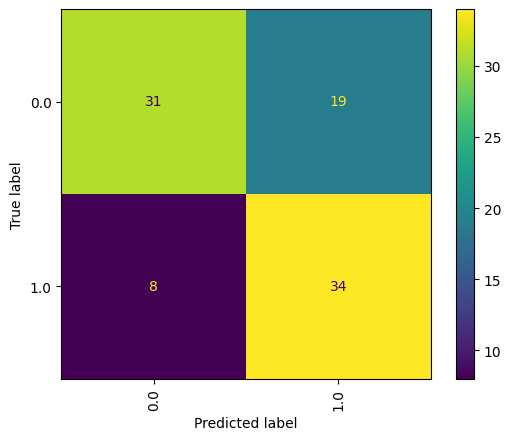

In [24]:
xgb_h = XGBClassifier(colsample_bytree=0.8, gamma=0, learning_rate=1.0, max_depth=5, 
                      n_estimators=50, reg_alpha=0, reg_lambda=0.1, subsample=0.8)


xgb_h.fit(X_train, y_train)

# Predict
y_pred = xgb_h.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    xgb_h, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Random Forest
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.7065217391304348
              precision    recall  f1-score   support

         0.0       0.79      0.62      0.70        50
         1.0       0.64      0.81      0.72        42

    accuracy                           0.71        92
   macro avg       0.72      0.71      0.71        92
weighted avg       0.72      0.71      0.71        92



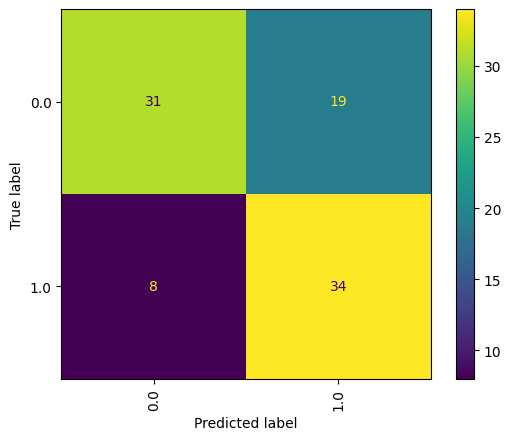

In [25]:
rfc_h = RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf=1, 
                                min_samples_split=10, n_estimators=50)


rfc_h.fit(X_train, y_train)

# Predict
y_pred = rfc_h.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(
    rfc_h, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Logistic Regression
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.5869565217391305
Classification Report:


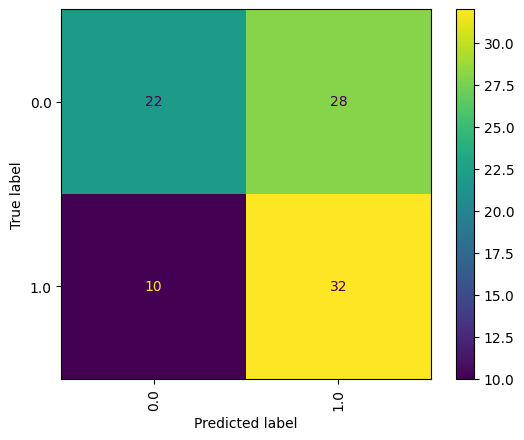

In [26]:
log_reg_h = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


# Train the model
log_reg_h.fit(X_train, y_train)

# Make predictions
y_pred = log_reg_h.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


print("Classification Report:")

ConfusionMatrixDisplay.from_estimator(
    log_reg_h, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Decision Tree
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.6413043478260869


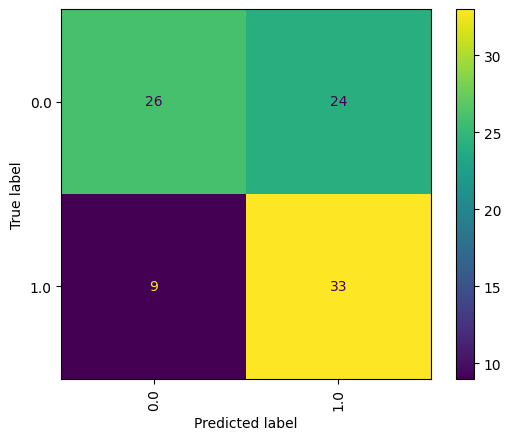

In [27]:
tree_clf_h = DecisionTreeClassifier(random_state=42, max_depth=10, max_features='sqrt',
                                    min_samples_leaf=2, min_samples_split=2)


# Train the classifier
tree_clf_h.fit(X_train, y_train)

# Make predictions
y_pred = tree_clf_h.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ConfusionMatrixDisplay.from_estimator(
    tree_clf_h, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### NB
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.5434782608695652


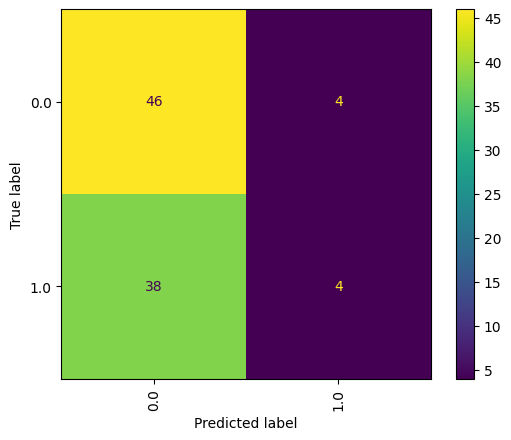

In [28]:
nb_clf_h = GaussianNB(var_smoothing = 1e-09)

# Train
nb_clf_h.fit(X_train, y_train)

# Make predictions
y_pred = nb_clf_h.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ConfusionMatrixDisplay.from_estimator(
    nb_clf_h, X_test, y_test, xticks_rotation="vertical"
)

--------------------------------------------------------------------------------------------------------------------------------
### Ada boost
--------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.5108695652173914


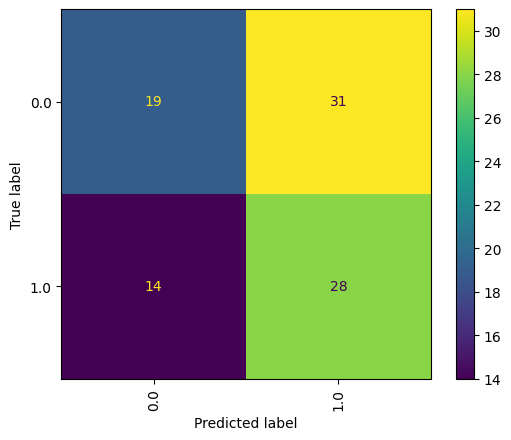

In [29]:
adaboost_clf_h = AdaBoostClassifier(n_estimators=50, random_state=42, algorithm = 'SAMME.R', learning_rate = 0.1)

# Train
adaboost_clf_h.fit(X_train, y_train)

# Make predictions 
y_pred = adaboost_clf_h.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ConfusionMatrixDisplay.from_estimator(
    adaboost_clf_h, X_test, y_test, xticks_rotation="vertical"
)

#### Like I can see the best model is Gradient Boosting Classifier with Accuracy: 0.7934782608695652 after finding the best parameters.

--------------------------------------------------------------------------------------------------------------------------------
# Deep Learning
--------------------------------------------------------------------------------------------------------------------------------

In [30]:
# load mat file
Xva = sp.io.loadmat("Xva.mat")
Xa = sp.io.loadmat("Xa.mat")
Rva_dl = Xva['Xva']
Ra_dl = Xa['Xa']

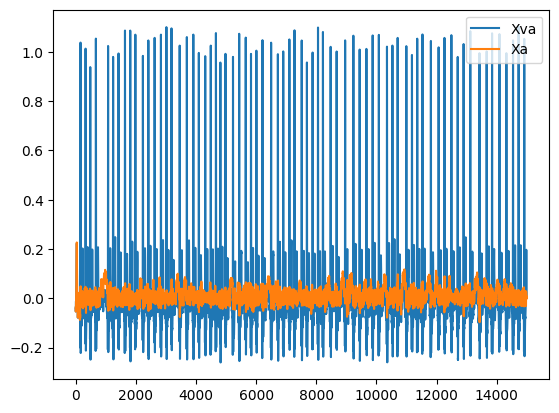

In [31]:
plt.figure()
plt.plot(Rva_dl[0,:,0])
plt.plot(Ra_dl[0,:,0])
plt.legend(['Xva','Xa'],loc='upper right')

In [32]:
# Reshape the matrices to match the input shape of the neural network
Rva_dl = Rva_dl[6:12, :, :]
Ra_dl = Ra_dl[6:12, :, :]

In [33]:
Rva_dl.shape

(6, 15000, 75)

In [34]:
# Reshape the matrices to match the input shape of the neural network
Rva_input = Rva_dl.transpose((1, 0, 2)).reshape((15000, 6 * 75)).T
Ra_output = Ra_dl.transpose((2, 0, 1)).reshape((15000, 6 * 75)).T

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(Rva_input, Ra_output, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=42)

#neural network model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(15000,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(15000, activation='linear'))  # Output layer with linear activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=15, batch_size=45, validation_data=(X_val, y_val))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)

# Trained model to predict Ra from Rva for new data
predicted_Ra = model.predict(X_test)
print(f'Test Loss: {loss}')

Epoch 1/15
4/4 [==============================] - 2s 201ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 2/15
4/4 [==============================] - 0s 105ms/step - loss: 0.0056 - val_loss: 0.0049
Epoch 3/15
4/4 [==============================] - 0s 95ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 4/15
4/4 [==============================] - 0s 76ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 5/15
4/4 [==============================] - 0s 77ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 6/15
4/4 [==============================] - 0s 68ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 7/15
4/4 [==============================] - 0s 68ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 8/15
4/4 [==============================] - 0s 73ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 9/15
4/4 [==============================] - 0s 68ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 10/15
4/4 [==============================] - 0s 67ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 11/15
4/4 [==========

Like I can see the loss is very low, the model is performing well

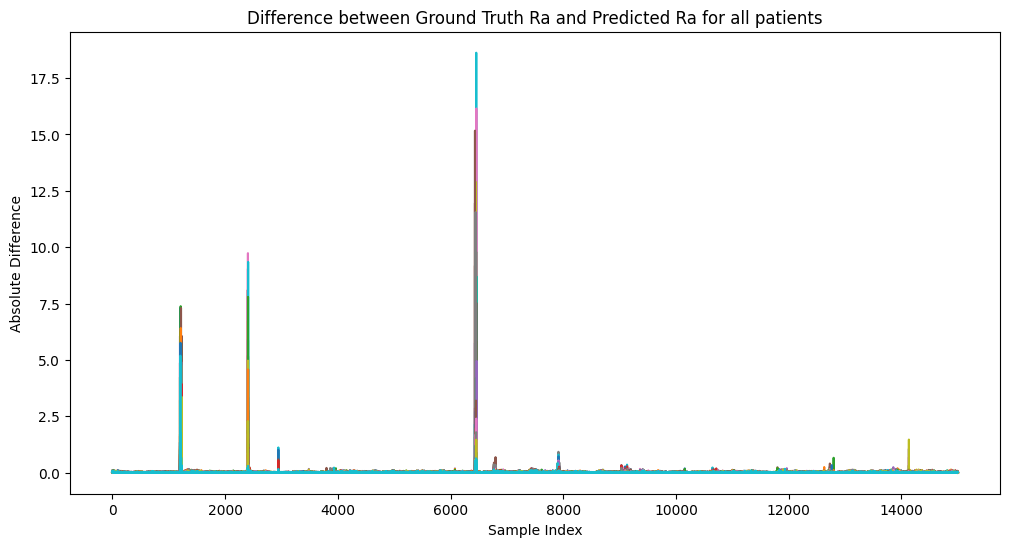

In [35]:
difference = abs(y_test - predicted_Ra)

plt.figure(figsize=(12, 6))
for patient_index in range(90):
    plt.plot(difference[patient_index, :])
plt.title('Difference between Ground Truth Ra and Predicted Ra for all patients')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Difference')
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predicted_Ra))
print('Root Mean Squared Error (RMSE):', rmse)

Root Mean Squared Error (RMSE): 0.06913956347897152


The RMSE is low, that's mean that on average, model's predictions are closer to the actual values.